## Build makemore part 3

ref: [link](https://youtu.be/P6sfmUTpUmc?si=RzKlyjAX76xuVNEs)

In [1]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words 
words = open('names.txt', 'r').read().splitlines()
words[:8], len(words)


(['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'],
 32033)

In [7]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [9]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])





torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [19]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,  generator=g)
W2 = torch.randn((n_hidden, vocab_size),  generator=g)
b2 = torch.randn(vocab_size,  generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [26]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,) ,generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    if i%1000 == 0:
        print(f'{i:7d}/{max_steps:7d}:{loss.item():4f}')
    
    lossi.append(loss.log10().item())

      0/ 200000:27.786318
   1000/ 200000:3.175574
   2000/ 200000:3.019442
   3000/ 200000:3.011967
   4000/ 200000:3.194317
   5000/ 200000:2.272421
   6000/ 200000:3.390795
   7000/ 200000:2.313213
   8000/ 200000:2.569918
   9000/ 200000:2.698135
  10000/ 200000:2.716024
  11000/ 200000:2.103650
  12000/ 200000:2.343048
  13000/ 200000:2.543094
  14000/ 200000:2.056311
  15000/ 200000:2.333560
  16000/ 200000:2.258273
  17000/ 200000:1.982258
  18000/ 200000:2.121075
  19000/ 200000:2.554124
  20000/ 200000:2.845383
  21000/ 200000:2.379811
  22000/ 200000:1.899595
  23000/ 200000:2.296866
  24000/ 200000:1.996233
  25000/ 200000:1.986699
  26000/ 200000:2.161963
  27000/ 200000:2.508444
  28000/ 200000:2.231983
  29000/ 200000:2.286645
  30000/ 200000:2.001054
  31000/ 200000:2.228453
  32000/ 200000:2.309313
  33000/ 200000:2.256622
  34000/ 200000:1.981870
  35000/ 200000:2.288657
  36000/ 200000:1.611940
  37000/ 200000:2.123038
  38000/ 200000:2.030658
  39000/ 200000:2.319519

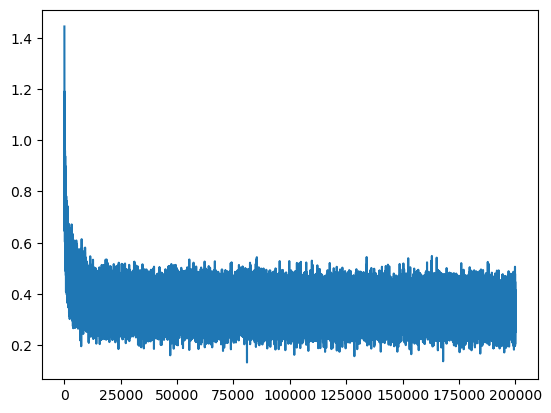

In [27]:
plt.plot(lossi)

In [28]:
@torch.no_grad()
def split_loss(split):
    x,y = {'train': (Xtr, Ytr),
           'val': (Xdev, Ydev),
           'test': (Xte, Yte)
           }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')


train 2.2285807132720947
val 2.2443244457244873


In [32]:
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1)@W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        
        ix = torch.multinomial(probs, num_samples = 1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))
        

mora.
mayah.
seel.
ndyn.
alarethrelejirlee.
aderedieliighly.
jenleigh.
esopharleithimson.
ami.
sadbergahiriel.
kendreelle.
jose.
caylon.
ged.
ryyah.
faelo.
kaysh.
sanyan.
hil.
salyansus.
